# **Import Packages**

In [ ]:
import os
import glob
import torch
import numpy as np
import pandas as pd
import os.path as osp
from PIL import Image
import torch.nn as nn
from numpy import mean
import torchvision as tv
from torch.utils import data
from google.colab import drive
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models

# from skimage import io
# from IPython.display import Image

torch.manual_seed(60)
%matplotlib inline

# **Dataset 1**

## **Dataset Preperation**

In [ ]:
# uploaded = files.upload()
# df = pd.read_csv(io.BytesIO(uploaded['training-a.csv']))
# df.head()

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/SCLab/Assignment2/training-a.csv')
df.head()

In [ ]:
df.drop(['original filename', 'scanid', 'database name original', 'contributing team', 'database name'], axis = 1, inplace = True)
df.to_csv('training_set.csv', index = False)
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/SCLab/Assignment2/training_set.csv')
df.shape

(19702, 2)

In [ ]:
class DigitDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform = None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path).convert('L')
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)
            
        return image, y_label

## **DNN Model**

In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()

        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()

        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()

        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()

        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()

        self.linear_5 = nn.Linear(num_hidden, num_hidden)
        self.relu_5 = nn.ReLU()

        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()

        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)

        out  = self.linear_3(out)
        out = self.relu_3(out)

        out  = self.linear_4(out)
        out = self.relu_4(out)

        out  = self.linear_5(out)
        out = self.relu_5(out)

        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas = self.linear_out(out)
        return probas

## **Model Training**

In [ ]:
batch_size = 20
num_iters = 20000
input_dim = 180*180
num_hidden = 200
output_dim = 10
learning_rate = 0.01
# number of hidden layers = 6

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

mean = 0.5
std = 0.5
custom_transform = transforms.Compose([transforms.Resize(180), transforms.ToTensor(), transforms.Normalize(mean, std)])
dataset = DigitDataset(csv_file = '/content/gdrive/MyDrive/Colab Notebooks/SCLab/Assignment2/training_set.csv',
                       root_dir = '/content/gdrive/MyDrive/Colab Notebooks/SCLab/Assignment2/training-a',
                       transform = custom_transform)

dataset_len = len(dataset)
train_len = int(dataset_len * 0.8)
test_len = dataset_len - train_len
train_set, test_set = data.random_split(dataset, [train_len, test_len])

num_epochs = num_iters / (len(train_set) / batch_size)
num_epochs = int(num_epochs)

train_loader = DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_set, batch_size = batch_size, shuffle = False)

print('Train loader: ', len(train_loader))
print('Test loader: ', len(test_loader))
print('Per image size: ', train_set[0][0].numpy().shape)
print('Sample label: 1st image: ', train_set[0][1])

cuda:0
Train loader:  789
Test loader:  198
Per image size:  (1, 180, 180)
Sample label: 1st image:  tensor(8)


In [ ]:
iter = 0
iter_list = []
loss_list = []

model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 180*180).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, labels)
        loss_list.append(loss)

        loss.backward()

        optimizer.step()

        iter += 1
        iter_list.append(iter)

        if iter % 500 == 0:       
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.view(-1, 180*180).to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.309992790222168. Accuracy: 9.895965490992134
Iteration: 1000. Loss: 2.3028972148895264. Accuracy: 9.71834559756407
Iteration: 1500. Loss: 2.2916483879089355. Accuracy: 9.972088302461303
Iteration: 2000. Loss: 2.3145415782928467. Accuracy: 10.09895965490992
Iteration: 2500. Loss: 2.3281219005584717. Accuracy: 10.504947982745495
Iteration: 3000. Loss: 2.297210216522217. Accuracy: 9.439228622177112
Iteration: 3500. Loss: 2.3001835346221924. Accuracy: 9.972088302461303
Iteration: 4000. Loss: 2.294147491455078. Accuracy: 9.972088302461303
Iteration: 4500. Loss: 2.3067867755889893. Accuracy: 9.895965490992134
Iteration: 5000. Loss: 2.2879340648651123. Accuracy: 9.819842679522964
Iteration: 5500. Loss: 2.292207717895508. Accuracy: 9.71834559756407
Iteration: 6000. Loss: 2.3236472606658936. Accuracy: 9.819842679522964
Iteration: 6500. Loss: 2.3063406944274902. Accuracy: 9.895965490992134
Iteration: 7000. Loss: 2.3076071739196777. Accuracy: 9.972088302461303
Iteration: 7

### **Save Model**

In [ ]:
root_path = '/content/gdrive/MyDrive/Colab Notebooks/SCLab/Assignment2/'
save_model = True

if save_model is True:
    torch.save(model.state_dict(), root_path + 'digit_classifier_dnn_exp1.pkl') 

### **Load Model**

In [ ]:
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(root_path + 'digit_classifier_dnn_exp1.pkl'))

## **Loss Curve**

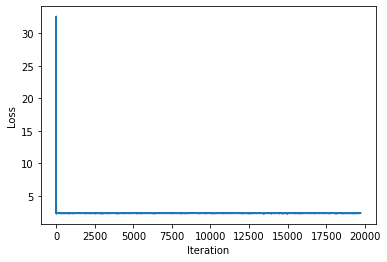

In [ ]:
plt.plot(iter_list, loss_list)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.savefig('loss_ex1.png')
plt.show()

# **Dataset 2**

## **Model Training**

In [ ]:
batch_size = 20
num_iters = 20000
input_dim = 28*28
num_hidden = 200
output_dim = 10
learning_rate = 0.01
# number of hidden layers = 6

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

train_set = datasets.FashionMNIST(root = './data', train = True, transform = transforms.ToTensor(), download = True)
test_set = datasets.FashionMNIST(root = './data', train = False, transform = transforms.ToTensor())

num_epochs = num_iters / (len(train_set) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_set, batch_size = batch_size, shuffle = False)

print('Train loader: ', len(train_loader))
print('Test loader: ', len(test_loader))
print('Per image size: ', train_set[0][0].numpy().shape)
print('Sample label: 1st image: ', train_set[0][1])

cuda:0


100.0%


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100.6%


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100.0%


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



119.3%

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw

Train loader:  3000
Test loader:  500
Per image size:  (1, 28, 28)
Sample label: 1st image:  9



C:\Users\faisa\Dev\Tools\anaconda3\envs\PyTorch190\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
iter = 0
iter_list = []
loss_list = []


model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, labels)
        loss_list.append(loss)

        loss.backward()

        optimizer.step()

        iter += 1
        iter_list.append(iter)

        if iter % 500 == 0:       
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.view(-1, 28*28).to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

C:\Users\faisa\Dev\Tools\anaconda3\envs\PyTorch190\lib\site-packages\torch\cuda\__init__.py:83: UserWarning: 
    Found GPU%d %s which is of cuda capability %d.%d.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is %d.%d.
    
  warnings.warn(old_gpu_warn.format(d, name, major, minor, min_arch // 10, min_arch % 10))


Iteration: 500. Loss: 0.9181587100028992. Accuracy: 63.62
Iteration: 1000. Loss: 0.787031888961792. Accuracy: 69.77
Iteration: 1500. Loss: 0.6704389452934265. Accuracy: 68.75
Iteration: 2000. Loss: 0.4942539632320404. Accuracy: 72.78
Iteration: 2500. Loss: 1.1130439043045044. Accuracy: 71.02
Iteration: 3000. Loss: 0.7626029253005981. Accuracy: 69.2
Iteration: 3500. Loss: 0.6898616552352905. Accuracy: 71.71
Iteration: 4000. Loss: 0.4016701579093933. Accuracy: 74.81
Iteration: 4500. Loss: 0.7102453112602234. Accuracy: 64.35
Iteration: 5000. Loss: 1.0515044927597046. Accuracy: 69.23
Iteration: 5500. Loss: 0.6421090364456177. Accuracy: 65.37
Iteration: 6000. Loss: 0.3975197374820709. Accuracy: 76.77
Iteration: 6500. Loss: 0.6021232008934021. Accuracy: 75.24
Iteration: 7000. Loss: 1.0589137077331543. Accuracy: 63.97
Iteration: 7500. Loss: 0.8309032320976257. Accuracy: 72.79
Iteration: 8000. Loss: 0.5602055788040161. Accuracy: 76.42
Iteration: 8500. Loss: 0.7040634155273438. Accuracy: 70.68


### **Save Model**

In [ ]:
root_path = '/content/gdrive/MyDrive/Colab Notebooks/SCLab/Assignment2/'
save_model = True

if save_model is True:
    torch.save(model.state_dict(), root_path + 'digit_classifier_dnn_exp1_1.pkl') 

### **Load Model**

In [ ]:
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(root_path + 'digit_classifier_dnn_exp1_1.pkl'))


## **Loss Curve**

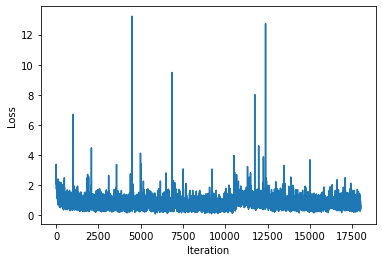

In [ ]:
perf = []
for i in range(len(iter_list)):
    perf.append([iter_list[i], loss_list[i].item()])
perf
plt.plot([i[0] for i in perf], [i[1] for i in perf])
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.savefig('loss_ex1_1.png')
plt.show()